In [1]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.misc import imread
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from lesson_helpers import *

import random as rand
import numpy as np 
import cv2
import glob
import time
import os

from moviepy.editor import VideoFileClip

import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
test_imgs = glob.glob('test_images/*.jpg')

### Lesson Helpers

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, transform_sqrt=False,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, transform_sqrt=False,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    
    for file in imgs:
        file_features = []
        # Read in each one by one
        # If LUV
        image = imread(file)   
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)              
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, transform_sqrt=transform_sqrt,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, transform_sqrt=transform_sqrt, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [4]:


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space=color_space, 
                                       spatial_size=spatial_size, 
                                       hist_bins=hist_bins, 
                                       orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, 
                                       hog_feat=hog_feat)
        
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 10)
    # Return the image
    return img

### Training Parameters

In [ ]:
train_params = {
    'color_space': 'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient': 9,  # HOG orientations
    'pix_per_cell': 16, # HOG pixels per cell <<<<<
    'cell_per_block': 2, # HOG cells per block
    'hog_channel': "ALL", # Can be 0, 1, 2, or "ALL"
    'transform_sqrt': False,
    'spatial_size': (24, 24), # Spatial binning dimensions
    'hist_bins': 24,    # Number of histogram bins
    'spatial_feat': True, # Spatial features on or off
    'hist_feat': True, # Histogram features on or off
    'hog_feat': True # HOG features on or off
}

### Training Class

In [6]:
class Trainer(object):
    
    def __init__(self, cars, notcars, params):
        self.cars = cars
        self.notcars = notcars
        self.color_space = params['color_space']
        self.spatial_size = params['spatial_size']
        self.hist_bins = params['hist_bins']
        self.orient = params['orient']
        self.pix_per_cell = params['pix_per_cell']
        self.cell_per_block = params['cell_per_block'] 
        self.hog_channel = params['hog_channel']
        self.transform_sqrt = params['transform_sqrt']
        self.spatial_feat = params['spatial_feat']
        self.hist_feat = params['hist_feat']
        self.hog_feat = params['hog_feat']
        
    """
    Todo: Add different methods of reading file based on file type
    """
    def read_img(self, file_path):       
        
        #LUV use sckit.imread
        return imread(file_path)    
        
   
    def trainer(self,
                cars, 
                notcars, 
                color_space, 
                spatial_size, 
                hist_bins, 
                orient, 
                pix_per_cell, 
                cell_per_block, 
                hog_channel, 
                spatial_feat, 
                hist_feat, 
                hog_feat):

#         print('Training...')

        car_features = extract_features(
            cars, 
            color_space=color_space, 
            spatial_size=spatial_size, 
            hist_bins=hist_bins, 
            orient=orient, 
            pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, 
            spatial_feat=spatial_feat, 
            hist_feat=hist_feat, 
            hog_feat=hog_feat)

        notcar_features = extract_features(
            notcars, 
            color_space=color_space, 
            spatial_size=spatial_size, 
            hist_bins=hist_bins, 
            orient=orient, 
            pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, 
            spatial_feat=spatial_feat, 
            hist_feat=hist_feat, 
            hog_feat=hog_feat)    

        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=72)

        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        
        # Use a linear SVC 
        svc = LinearSVC(C=3)
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        
        self.svc = svc
        self.X_scaler = X_scaler

        return svc, X_scaler
    
    def train(self):
        return self.trainer(
            self.cars, 
            self.notcars, 
            self.color_space, 
            self.spatial_size, 
            self.hist_bins, 
            self.orient, 
            self.pix_per_cell, 
            self.cell_per_block, 
            self.hog_channel, 
            self.spatial_feat, 
            self.hist_feat, 
            self.hog_feat)
        
        

### Testing Class

In [7]:
class Tester(object):
    
    def __init__(self, img, trainer, win_params):
        self.img = img
        self.trainer = trainer
        self.x_start_stop = win_params['x_start_stop']
        self.y_start_stop = win_params['y_start_stop']
        self.xy_window = win_params['xy_window']
        self.xy_overlap = win_params['xy_overlap']
                
    def tester(
        self, 
        img, 
        svc, 
        X_scaler, 
        color_space,
        spatial_size,
        hist_bins,
        orient,
        pix_per_cell,
        cell_per_block, 
        hog_channel,
        transform_sqrt,
        spatial_feat, 
        hist_feat, 
        hog_feat,
        x_start_stop,
        y_start_stop, 
        xy_window, 
        xy_overlap):
            
        draw_image = np.copy(img)

        windows = slide_window(img, 
                               x_start_stop=x_start_stop, 
                               y_start_stop=y_start_stop, 
                               xy_window=xy_window, 
                               xy_overlap=xy_overlap)

        hot_windows = search_windows(img, 
                                     windows, 
                                     svc, 
                                     X_scaler, 
                                     color_space=color_space, 
                                     spatial_size=spatial_size, 
                                     hist_bins=hist_bins, 
                                     orient=orient, 
                                     pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, 
    #                                  transform_sqrt = transform_sqrt,
                                     spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, 
                                     hog_feat=hog_feat)                       

        window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=3)                    
        
        return hot_windows, window_img
        
    def test(self):
        return self.tester(
            self.img, 
            self.trainer.svc, 
            self.trainer.X_scaler, 
            self.trainer.color_space,
            self.trainer.spatial_size,
            self.trainer.hist_bins,
            self.trainer.orient,
            self.trainer.pix_per_cell,
            self.trainer.cell_per_block, 
            self.trainer.hog_channel,
            self.trainer.transform_sqrt,
            self.trainer.spatial_feat, 
            self.trainer.hist_feat, 
            self.trainer.hog_feat,
            self.x_start_stop,
            self.y_start_stop, 
            self.xy_window, 
            self.xy_overlap)

### Sliding Window Class

In [19]:
class Slider(object):
    
    def __init__(self, trainer, windows):
        self.windows = windows
        self.trainer = trainer
        
    def searcher(
        self, 
        img, 
        svc, 
        X_scaler, 
        color_space,
        spatial_size,
        hist_bins,
        orient,
        pix_per_cell,
        cell_per_block, 
        hog_channel,
        transform_sqrt,
        spatial_feat, 
        hist_feat, 
        hog_feat,
        windows):
            
#         draw_image = np.copy(img)

        hot_windows = search_windows(img, 
                                     windows, 
                                     svc, 
                                     X_scaler, 
                                     color_space=color_space, 
                                     spatial_size=spatial_size, 
                                     hist_bins=hist_bins, 
                                     orient=orient, 
                                     pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, 
    #                                  transform_sqrt = transform_sqrt,
                                     spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, 
                                     hog_feat=hog_feat)                       

#         window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=3)                    
        
        return hot_windows     
        
    def search(self, img):
        return self.searcher(
            img, 
            self.trainer.svc, 
            self.trainer.X_scaler, 
            self.trainer.color_space,
            self.trainer.spatial_size,
            self.trainer.hist_bins,
            self.trainer.orient,
            self.trainer.pix_per_cell,
            self.trainer.cell_per_block, 
            self.trainer.hog_channel,
            self.trainer.transform_sqrt,
            self.trainer.spatial_feat, 
            self.trainer.hist_feat, 
            self.trainer.hog_feat,
            self.windows)

### Heat Map Class

In [9]:
class Heat_Mapper(object):
    
    def __init__(self, img, box_list, threshold):
        self.img = img
        self.box_list = box_list
        self.threshold = threshold
        self.heatmap = None
        
    def heat_mapper(self):
        heat = np.zeros_like(self.img[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = add_heat(heat, self.box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        self.heatmap = heatmap
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(self.img), labels)

        return draw_img

### Demo Pipeline

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2772
5.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


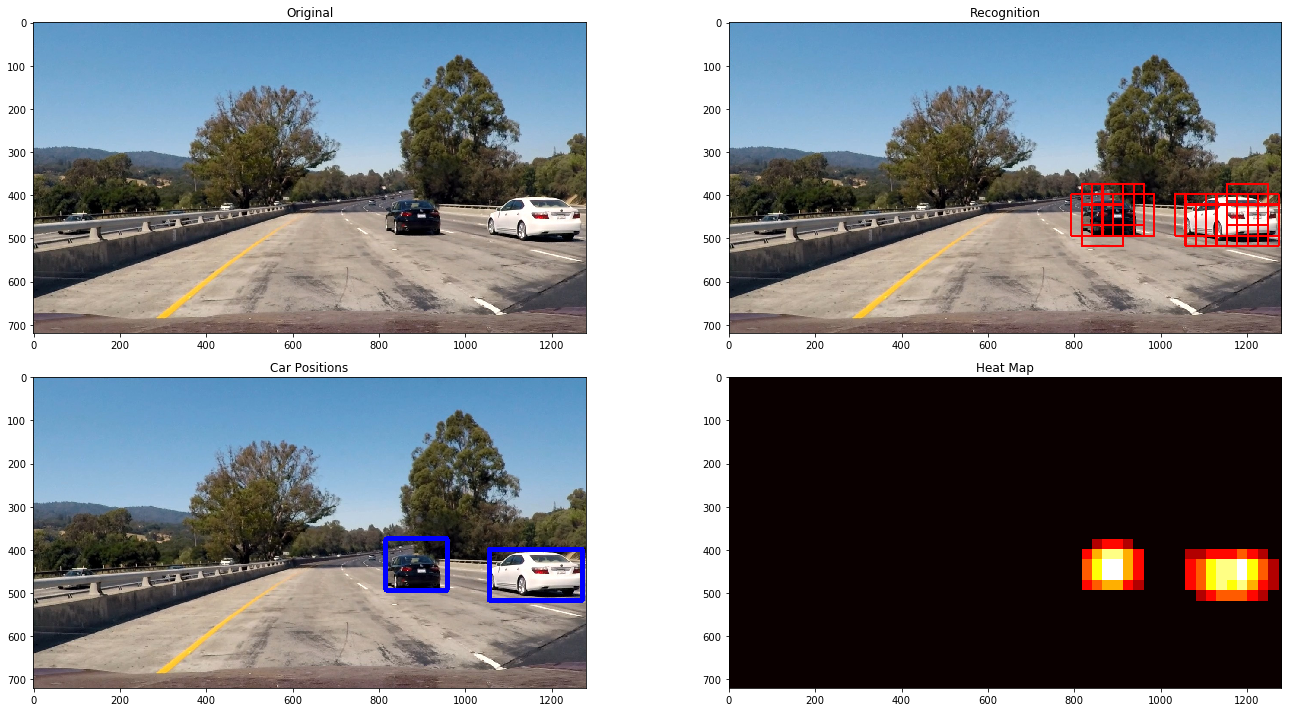

In [11]:
# Parameters Setup

demo_train_params = {
    'color_space': 'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient': 9,  # HOG orientations
    'pix_per_cell': 16, # HOG pixels per cell <<<<<
    'cell_per_block': 2, # HOG cells per block
    'hog_channel': "ALL", # Can be 0, 1, 2, or "ALL"
    'transform_sqrt': False,
    'spatial_size': (24, 24), # Spatial binning dimensions
    'hist_bins': 24,    # Number of histogram bins
    'spatial_feat': True, # Spatial features on or off
    'hist_feat': True, # Histogram features on or off
    'hog_feat': True # HOG features on or off
}

demo_win_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 700], # Min and max in y to search in slide_window()
    'xy_window': (96, 96),
    'xy_overlap': (.75,.75)
}

# Set Data
demo_img = imread(test_imgs[0])

# Train data set
demo_trainer = Trainer(cars, notcars, demo_train_params)
demo_svc, demo_X_scaler = demo_trainer.train()

# Get windows data set
demo_tester = Tester(demo_img, demo_trainer, demo_win_params)
demo_windows, demo_windows_img = demo_tester.test()

# Get heat map
demo_threshold = 1
demo_heat_mapper = Heat_Mapper(demo_img, demo_windows, demo_threshold)
demo_heat_map_img = demo_heat_mapper.heat_mapper()

# Display Results
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(demo_img)
plt.title('Original')
plt.subplot(222)
plt.imshow(demo_windows_img)
plt.title('Recognition')
plt.subplot(223)
plt.imshow(demo_heat_map_img)
plt.title('Car Positions')
plt.subplot(224)
plt.imshow(demo_heat_mapper.heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()

### Sliding Window Parameter Trials

In [ ]:
win_params0 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 500], # Min and max in y to search in slide_window()
    'xy_window': (32, 32),
    'xy_overlap': (.5,.5)
}

win_params1 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 550], # Min and max in y to search in slide_window()
    'xy_window': (64, 64),
    'xy_overlap': (.75,.75)
}

win_params2 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 700], # Min and max in y to search in slide_window()
    'xy_window': (96, 96),
    'xy_overlap': (.75,.75)
}

win_params3 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 700], # Min and max in y to search in slide_window()
    'xy_window': (128, 128),
    'xy_overlap': (.75,.75)
}

win_params4 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 700], # Min and max in y to search in slide_window()
    'xy_window': (192, 192),
    'xy_overlap': (.75,.75)
}

In [ ]:
def get_hot_windows(img, trainer, win_params, img_path='', view_results=False, save_results=False):

    hot_windows = []
    hot_windows_imgs = []

    for win_param in win_params:
        tester_obj = Tester(img, trainer, win_param)
        hot_windows_results, img_results = tester_obj.test()

        hot_windows.append(hot_windows_results)
        hot_windows_imgs.append(hot_windows_imgs)
        
        if view_results:
            plt.figure()
            plt.title('window: ' + str(win_param['xy_window']))
            plt.imshow(img_results)
            
        if save_results:
            plt.figure()
            plt.title('window: ' + str(win_param['xy_window']))
            plt.imshow(img_results)
            file_name = os.path.splitext(os.path.basename(img_path))[0]
            plt.savefig("figure_analysis/" + file_name + "_windows_" + str(win_param['xy_window'][0]) +"x"+ str(win_param['xy_window'][1]) + ".png")

    return hot_windows, hot_windows_imgs

In [ ]:
win_params = [win_params0, win_params1, win_params2, win_params3, win_params4]

for test_img_path in test_imgs:   
    img = imread(test_img_path)
    get_hot_windows(img, trainer_obj, win_params, img_path=test_img_path, view_results=False, save_results=True)    

### Pipeline Class

In [ ]:
# Parameters Setup



def test_pipeline(img, view_results=False):

    # Set Data
    test_img = imread(test_imgs[0])

    # Train data set
    trainer = Trainer(cars, notcars, train_params)
    svc, X_scaler = trainer.train()

    # Get windows data set
    demo_tester = Tester(demo_img, demo_trainer, demo_win_params)
    demo_windows, demo_windows_img = demo_tester.test()

    # Get heat map
    demo_threshold = 1
    demo_heat_mapper = Heat_Mapper(demo_img, demo_windows, demo_threshold)
    demo_heat_map_img = demo_heat_mapper.heat_mapper()

    if view_results:
        
        # Display Results
        plt.figure(figsize=(20,10))
        plt.subplot(221)
        plt.imshow(demo_img)
        plt.title('Original')
        plt.subplot(222)
        plt.imshow(demo_windows_img)
        plt.title('Recognition')
        plt.subplot(223)
        plt.imshow(demo_heat_map_img)
        plt.title('Car Positions')
        plt.subplot(224)
        plt.imshow(demo_heat_mapper.heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    


In [12]:
# Global Parameters
g_train_params = {
    'color_space': 'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient': 9,  # HOG orientations
    'pix_per_cell': 16, # HOG pixels per cell <<<<<
    'cell_per_block': 2, # HOG cells per block
    'hog_channel': "ALL", # Can be 0, 1, 2, or "ALL"
    'transform_sqrt': False,
    'spatial_size': (24, 24), # Spatial binning dimensions
    'hist_bins': 24,    # Number of histogram bins
    'spatial_feat': True, # Spatial features on or off
    'hist_feat': True, # Histogram features on or off
    'hog_feat': True # HOG features on or off
}

In [13]:
# All Window Parameters
win_params_0 = {
    'x_start_stop': [200, 1000],
    'y_start_stop': [350, 450], # Min and max in y to search in slide_window()
    'xy_window': (32, 32),
    'xy_overlap': (.5,.5)
}

win_params_1 = {
    'x_start_stop': [200, 1000],
    'y_start_stop': [350, 550], # Min and max in y to search in slide_window()
    'xy_window': (64, 64),
    'xy_overlap': (.8,.8)
}

win_params_2 = {
    'x_start_stop': [None, None],
    'y_start_stop': [300, 650], # Min and max in y to search in slide_window()
    'xy_window': (96, 96),
    'xy_overlap': (.8,.8)
}

win_params_3 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 650], # Min and max in y to search in slide_window()
    'xy_window': (128, 128),
    'xy_overlap': (.75,.75)
}

win_params_4 = {
    'x_start_stop': [None, None],
    'y_start_stop': [500, 650], # Min and max in y to search in slide_window()
    'xy_window': (192, 192),
    'xy_overlap': (.75,.75)
}

win_params_5 = {
    'x_start_stop': [None, None],
    'y_start_stop': [500, 650], # Min and max in y to search in slide_window()
    'xy_window': (96, 128),
    'xy_overlap': (.75,.75)
}

In [14]:
g_win_params = [win_params_0, win_params_1, win_params_2, win_params_3, win_params_4, win_params_5]

In [15]:
def get_all_slide_windows(img, params=[]):
    windows = []
    
    for param in params:
        windows += (slide_window(
            img, 
            x_start_stop=param['x_start_stop'], 
            y_start_stop=param['y_start_stop'], 
            xy_window=param['xy_window'], 
            xy_overlap=param['xy_overlap']))
    
    return windows

In [16]:
# Must assum that the test image has the same dimensions as the video
g_slide_windows = get_all_slide_windows(imread(test_imgs[0]), g_win_params)
print(len(g_slide_windows), "Windows to check")

2143 Windows to check


In [17]:
# Get the global trainer
g_trainer = Trainer(cars, notcars, g_train_params)
g_svc, g_X_scaler = g_trainer.train()

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2772
5.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


In [20]:
# Get the global slider
g_slider = Slider(g_trainer, g_slide_windows)

In [21]:
class Pipeline:
    
    def __init__(self, trainer, slider, threshold=2):
        self.trainer = trainer
        self.slider = slider
        self.threshold = threshold
        
    def debug_frame(self, img, threshold=2):
        hot_windows = self.slider.search(img)
        
        # Show the search results
        search_results = draw_boxes(img, hot_windows, color=(255, 0, 0), thick=3)       
        
        # Heat map results
        heat_mapper = Heat_Mapper(img, hot_windows, threshold)
        heat_map_img = heat_mapper.heat_mapper()
        
        return search_results, heat_map_img, heat_mapper.heatmap
        
    def go(self, img):
        hot_windows = self.slider.search(img)  
        
        heat_mapper = Heat_Mapper(img, hot_windows, self.threshold)
        result_img = heat_mapper.heat_mapper()
        
        # Heat map results
        return result_img

In [ ]:
# Create the pipeline
pipeline = Pipeline(g_trainer, g_slider, 3)

In [ ]:
test_pipe_img = imread(test_imgs[3])

sr, hm_img, hm = pipeline.debug_frame(test_pipe_img)

In [ ]:
g_tp = str(g_train_params).replace(',', '\n')

# Display Results
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(test_pipe_img)
plt.title('Original')
plt.subplot(222)
plt.imshow(sr)
plt.title('Recognition')
plt.subplot(223)
plt.imshow(hm_img)
plt.title('Car Positions')
plt.subplot(224)
plt.imshow(hm, cmap='hot')
plt.title('Heat Map')
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.axis('off')
plt.text(0, .1, g_tp, fontsize=15)
plt.subplot(122)
plt.axis('off')
fig.tight_layout()

In [ ]:
output = 'project_video_output_trial_19.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(25,30)
output_clip = clip1.fl_image(pipeline.go) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

### Extracting Video Frames For Debugging

In [ ]:
vidcap = cv2.VideoCapture('project_video_output_trial.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success, image = vidcap.read()
#     print('Read a new frame: ', success)
    cv2.imwrite("test_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

### Debugging

In [22]:
problem_frames = glob.glob('test_frames/*.jpg')

1676 Windows to check


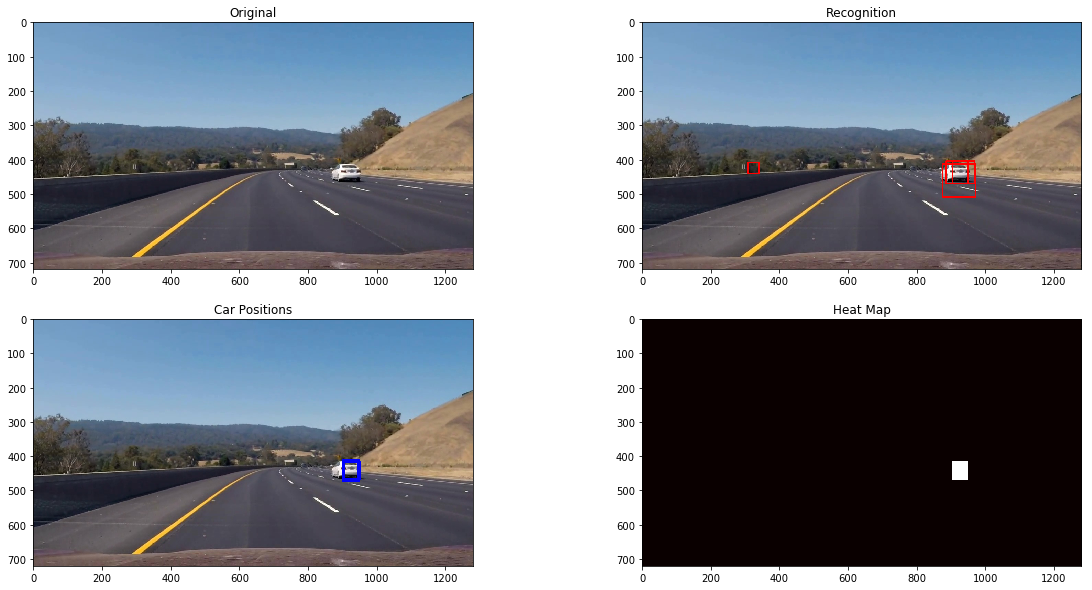

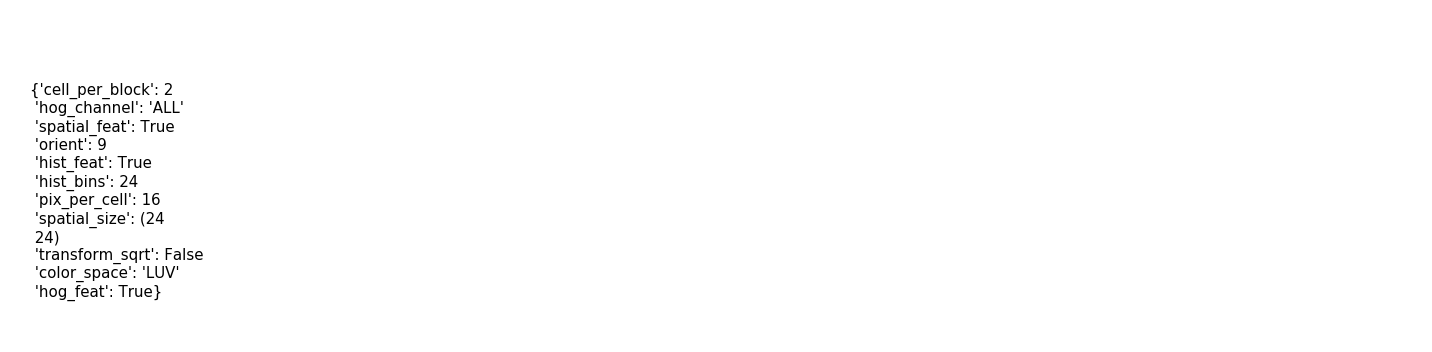

In [26]:
# All Window Parameters
win_params_0 = {
    'x_start_stop': [200, 1000],
    'y_start_stop': [350, 450], # Min and max in y to search in slide_window()
    'xy_window': (32, 32),
    'xy_overlap': (.6,.6)
}

win_params_1 = {
    'x_start_stop': [200, 1000],
    'y_start_stop': [350, 550], # Min and max in y to search in slide_window()
    'xy_window': (64, 64),
    'xy_overlap': (.7,.7)
}

win_params_2 = {
    'x_start_stop': [None, None],
    'y_start_stop': [300, 650], # Min and max in y to search in slide_window()
    'xy_window': (96, 96),
    'xy_overlap': (.8,.8)
}

win_params_3 = {
    'x_start_stop': [None, None],
    'y_start_stop': [350, 650], # Min and max in y to search in slide_window()
    'xy_window': (128, 128),
    'xy_overlap': (.6,.6)
}

win_params_4 = {
    'x_start_stop': [None, None],
    'y_start_stop': [500, 650], # Min and max in y to search in slide_window()
    'xy_window': (192, 192),
    'xy_overlap': (.6,.6)
}

g_win_params = [win_params_0, win_params_1, win_params_2, win_params_3, win_params_4]

# Must assum that the test image has the same dimensions as the video
g_slide_windows = get_all_slide_windows(imread(test_imgs[0]), g_win_params)
print(len(g_slide_windows), "Windows to check")

# Get the global slider
g_slider = Slider(g_trainer, g_slide_windows)

# Create the pipeline
debug_pipeline = Pipeline(g_trainer, g_slider, 2)

p_frame_0 = imread(problem_frames[50])
sr, hm_img, hm = debug_pipeline.debug_frame(p_frame_0, 2)

g_tp = str(g_train_params).replace(',', '\n')

# Display Results
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(p_frame_0)
plt.title('Original')
plt.subplot(222)
plt.imshow(sr)
plt.title('Recognition')
plt.subplot(223)
plt.imshow(hm_img)
plt.title('Car Positions')
plt.subplot(224)
plt.imshow(hm, cmap='hot')
plt.title('Heat Map')
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.axis('off')
plt.text(0, .1, g_tp, fontsize=15)
plt.subplot(122)
plt.axis('off')
plt.tight_layout()

In [ ]:
output = 'project_video_output_trial_21.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(29,31)
output_clip = clip1.fl_image(debug_pipeline.go) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_trial_21.mp4
[MoviePy] Writing video project_video_output_trial_21.mp4


 71%|███████   | 36/51 [03:23<01:25,  5.67s/it]

In [ ]:
# Output Test Images

for test_img in test_imgs:
    
    test_frame = imread(test_img)
    sr, hm_img, hm = debug_pipeline.debug_frame(test_frame, 4)

    g_tp = str(g_train_params).replace(',', '\n')

    # Display Results
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(test_frame)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(sr)
    plt.title('Recognition')
    plt.subplot(223)
    plt.imshow(hm_img)
    plt.title('Car Positions')
    plt.subplot(224)
    plt.imshow(hm, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

    #save the Results to a file
    file_name = os.path.splitext(os.path.basename(test_img))[0]
    plt.savefig('output_images/' + file_name + '_output.png')